#### 한글폰트 깨짐 현상 개선하기

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 2s (5,257 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 155335 files and d

위 셀 실행 후 런타임 다시시작

In [25]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 

### 모듈 가져오기

In [3]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
cd /content/drive/MyDrive/ColabNotebooks/AI_service_develop

/content/drive/MyDrive/ColabNotebooks/AI_service_develop


In [6]:
img_size = 224
channel=3

In [7]:
train_datagen = ImageDataGenerator( 
        rescale=1./255,         # 픽셀 값을 0~1 범위로 변환
        rotation_range=40,      # 40도까지 회전
        width_shift_range=0.2,  # 20%까지 좌우 이동
        height_shift_range=0.2, # 20%까지 상하 이동
        shear_range=0.2,        # 20%까지 기울임
        zoom_range=0.2,         # 20%까지 확대
        horizontal_flip=True,   # 좌우 뒤집기
    )
train_generator = train_datagen.flow_from_directory(
    './dataset/train_10',
    batch_size=50,      
    class_mode='categorical', 
    target_size=(img_size, img_size)) 
valid_datagen = ImageDataGenerator(rescale=1./255) # 스케일링만 진행
valid_generator = valid_datagen.flow_from_directory(
    './dataset/valid_10',
    batch_size=20,      
    class_mode='categorical', 
    target_size=(img_size, img_size))
test_datagen = ImageDataGenerator(rescale=1./255) # 스케일링만 진행
test_generator = test_datagen.flow_from_directory(
    './dataset/test_10',
    batch_size=10,      
    class_mode='categorical', 
    target_size=(img_size, img_size),
    shuffle=False)

Found 10529 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 500 images belonging to 10 classes.


In [8]:
print('train_generator class : ', train_generator.class_indices)
print('valid_generator class : ', valid_generator.class_indices)
print('test_generator class : ', test_generator.class_indices)

train_generator class :  {'갈아만든배': 0, '레쓰비': 1, '마운틴듀': 2, '밀키스': 3, '스프라이트': 4, '칠성사이다': 5, '코카콜라': 6, '트로피카나망고': 7, '펩시콜라': 8, '환타오렌지': 9}
valid_generator class :  {'갈아만든배': 0, '레쓰비': 1, '마운틴듀': 2, '밀키스': 3, '스프라이트': 4, '칠성사이다': 5, '코카콜라': 6, '트로피카나망고': 7, '펩시콜라': 8, '환타오렌지': 9}
test_generator class :  {'갈아만든배': 0, '레쓰비': 1, '마운틴듀': 2, '밀키스': 3, '스프라이트': 4, '칠성사이다': 5, '코카콜라': 6, '트로피카나망고': 7, '펩시콜라': 8, '환타오렌지': 9}


### 모델 학습하기 - MobileNetV2
- imagenet 전이학습
- 은닉층
   * Flatten(input_shape=(112,112))
   * Dense(224, activation='relu')
   * Dropout(0.2)
- 출력층
   * Dense(10, activation='softmax')
- compile
   * learning rate : 0.0001

In [9]:
# 파라미터 설정
classes = len(train_generator.class_indices)
epochs = 200
batch_size = 32

In [10]:
MobileNet = tf.keras.applications.MobileNetV2(weights='imagenet',
                                              include_top=False, 
                                              input_shape=(img_size, img_size, channel))
MobileNet.trainable = False # 학습으로 기존 가중치 갱신을 하지 않도록 지정

9420800/9406464 [==============================] - 0s 0us/step


In [11]:
model = Sequential()
model.add(MobileNet)
model.add(Flatten(input_shape=(112,112)))
model.add(Dense(224, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 224)               14049504  
                                                                 
 dropout (Dropout)           (None, 224)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2250      
                                                                 
Total params: 16,309,738
Trainable params: 14,051,754
Non-trainable params: 2,257,984
____________________________________

In [12]:
# 모델 환경설정
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
model_name = './model/MobileNetV2_TransferLearning02_{epoch:02d}-{val_loss:.4f}.hdf5'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = model_name,
                                                 save_weights_only=True, 
                                                 save_freq="epoch")
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

In [14]:
history = model.fit(train_generator,
                    steps_per_epoch=200, 
                    epochs=epochs, 
                    validation_data=valid_generator, 
                    validation_steps=40,
                    callbacks = [[earlystop, cp_callback]]) 

Epoch 1/200
200/200 [==============================] - 2696s 13s/step - loss: 0.5100 - accuracy: 0.8359 - val_loss: 0.0907 - val_accuracy: 0.9650
Epoch 2/200
200/200 [==============================] - 270s 1s/step - loss: 0.1440 - accuracy: 0.9503 - val_loss: 0.0738 - val_accuracy: 0.9737
Epoch 3/200
200/200 [==============================] - 125s 624ms/step - loss: 0.1115 - accuracy: 0.9629 - val_loss: 0.0400 - val_accuracy: 0.9875
Epoch 4/200
200/200 [==============================] - 116s 578ms/step - loss: 0.0995 - accuracy: 0.9666 - val_loss: 0.0243 - val_accuracy: 0.9900
Epoch 5/200
200/200 [==============================] - 114s 572ms/step - loss: 0.0995 - accuracy: 0.9682 - val_loss: 0.0226 - val_accuracy: 0.9950
Epoch 6/200
200/200 [==============================] - 114s 569ms/step - loss: 0.0913 - accuracy: 0.9687 - val_loss: 0.0208 - val_accuracy: 0.9912
Epoch 7/200
200/200 [==============================] - 114s 569ms/step - loss: 0.0631 - accuracy: 0.9775 - val_loss: 0.025

In [ ]:
max(history.history['accuracy'])

In [16]:
# 모델 저장
accuracy = round(max(history.history['accuracy'])*100,0)
model.save(f'./model/MobileNetV2_05_model_acc{accuracy}.h5') # 최종 모델 저장

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


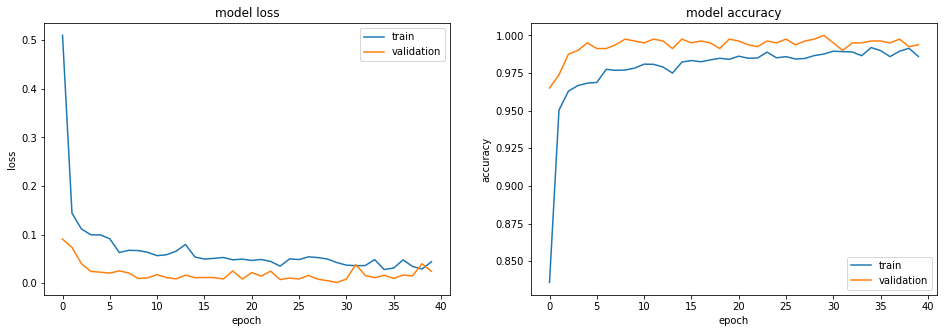

In [17]:
plt.figure(figsize=(16,5))

# 만들어진 모델에 대해 train dataset과 validation dataset의 loss 를 그래프로 표현해 봅니다.
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc=0)

# 만들어진 모델에 대해 train dataset과 validation dataset의 accuracy 를 그래프로 표현해 봅니다.
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc=0)

In [18]:
model.evaluate(test_generator)

50/50 [==============================] - 166s 3s/step - loss: 3.7237e-04 - accuracy: 1.0000


[0.000372372247511521, 1.0]